# Diamond Price Prediction (Regression)

Dataset Link: https://www.kaggle.com/datasets/shivam2503/diamonds/data  

Algorithms: Linear Regression, Random Forest

## Load Dataset

In [56]:
import pandas as pd                                                             # for data analysis, cleaning and exploration
import numpy as np                                                              # for numerical operations                        
import matplotlib.pyplot as plt                                                 # for data visualization 
import seaborn as sns                                                           # for statiscal visualization
from sklearn.feature_selection import mutual_info_regression                    # for feature selection
from sklearn.model_selection import train_test_split                            # split train and test data
from sklearn.preprocessing import StandardScaler                                # normalize data
from sklearn.linear_model import LinearRegression                               # linear regression model
from sklearn.linear_model import Ridge, Lasso, ElasticNet                       # regularization models
from sklearn.model_selection import GridSearchCV                                # hyperparameter tuning
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error   # model evaluation
from sklearn.ensemble import RandomForestRegressor                              # random forest model

In [57]:
# Load the data
data = pd.read_csv('diamonds.csv')
data

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,53937,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,53938,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,53939,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


### **Dataset Description:** 

**price:** price in US dollars (\$326--\$18,823)

**carat:** weight of the diamond (0.2--5.01)

**cut:** quality of the cut (Fair, Good, Very Good, Premium, Ideal)

**color:** diamond colour, from J (worst) to D (best)

**clarity:** a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

**x:** length in mm (0--10.74)

**y:** width in mm (0--58.9)

**z:** depth in mm (0--31.8)

**depth:** total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

**table:** width of top of diamond relative to widest point (43--95)

## Data Preprocessing

In [58]:
# remove the first column
data = data.drop(data.columns[0], axis=1)

In [59]:
# check for missing values
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [60]:
# check for duplicates
data.duplicated().sum()
print("{} duplicates".format(data.duplicated().sum()))

# remove duplicates
data = data.drop_duplicates()


146 duplicates


# Exploratory Data Analysis (EDA)

In [61]:
# summary of the data
data.describe()

,carat,depth,table,price,x,y,z
count,53794.00000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000,53794.000000
mean,0.79778,61.748080,57.458109,3933.065082,5.731214,5.734653,3.538714
std,0.47339,1.429909,2.233679,3988.114460,1.120695,1.141209,0.705037
min,0.20000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.40000,61.000000,56.000000,951.000000,4.710000,4.720000,2.910000
50%,0.70000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.04000,62.500000,59.000000,5326.750000,6.540000,6.540000,4.030000
max,5.01000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


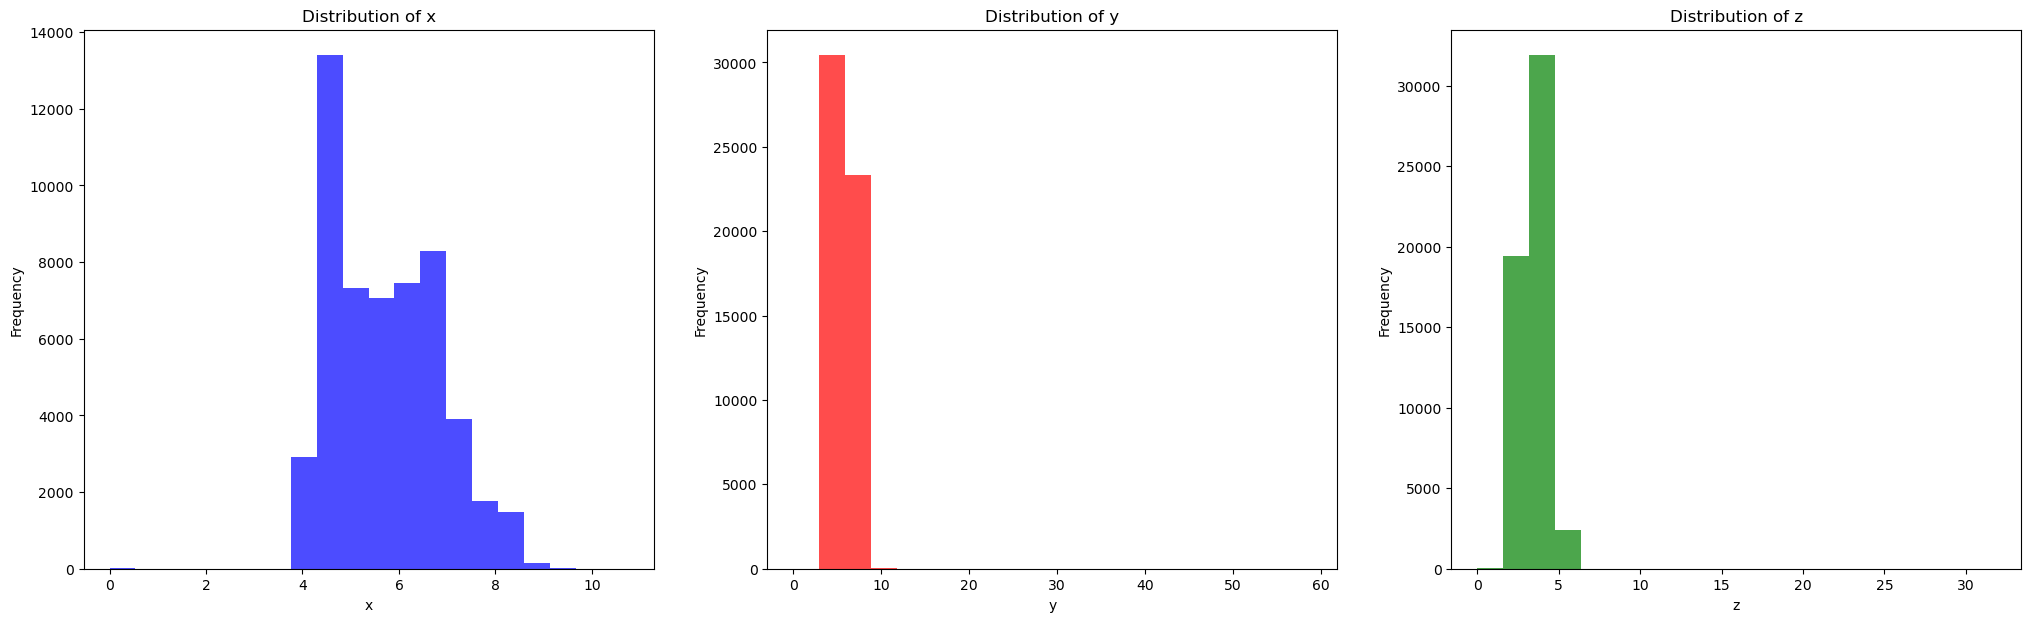

In [62]:
# Distribution of x, y, z
plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
plt.hist(data['x'], bins=20, color='blue', alpha=0.7)
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Distribution of x')

plt.subplot(1, 3, 2)
plt.hist(data['y'], bins=20, color='red', alpha=0.7)
plt.xlabel('y')
plt.ylabel('Frequency')
plt.title('Distribution of y')

plt.subplot(1, 3, 3)
plt.hist(data['z'], bins=20, color='green', alpha=0.7)
plt.xlabel('z')
plt.ylabel('Frequency')
plt.title('Distribution of z')
plt.show()


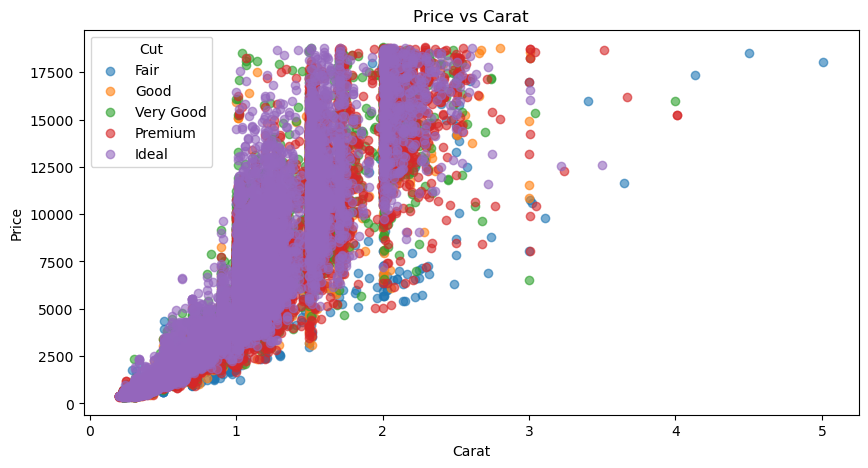

In [63]:
# find relationship between price and carat and cuts as legend 
plt.figure(figsize=(10, 5))
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
for cut in cut_order:
    subset = data[data['cut'] == cut]
    plt.scatter(subset['carat'], subset['price'], label=cut, alpha=0.6)

plt.xlabel('Carat')
plt.ylabel('Price')
plt.title('Price vs Carat')
plt.legend(title="Cut")
plt.show()

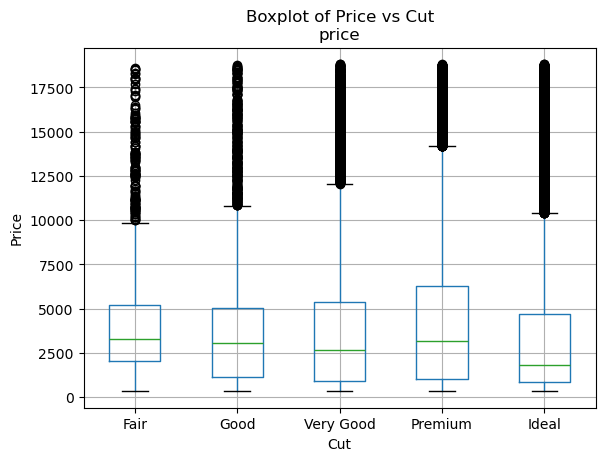

In [64]:
# Find distribution between price and cuts sort by fair, good, very good, premium, ideal
data['cut'] = pd.Categorical(data['cut'], categories=cut_order, ordered=True)
data.boxplot(column='price', by='cut')
plt.xlabel('Cut')
plt.ylabel('Price')
plt.suptitle('Boxplot of Price vs Cut')
plt.show()


## Correlation Matrix


In [65]:
# turn categorical data into numerical data (one hot encoding)
data = pd.get_dummies(data)
data.head()


,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Very Good,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,3.89,3.84,2.31,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,4.05,4.07,2.31,False,True,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,4.20,4.23,2.63,False,False,False,...,True,False,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,4.34,4.35,2.75,False,True,False,...,False,True,False,False,False,True,False,False,False,False


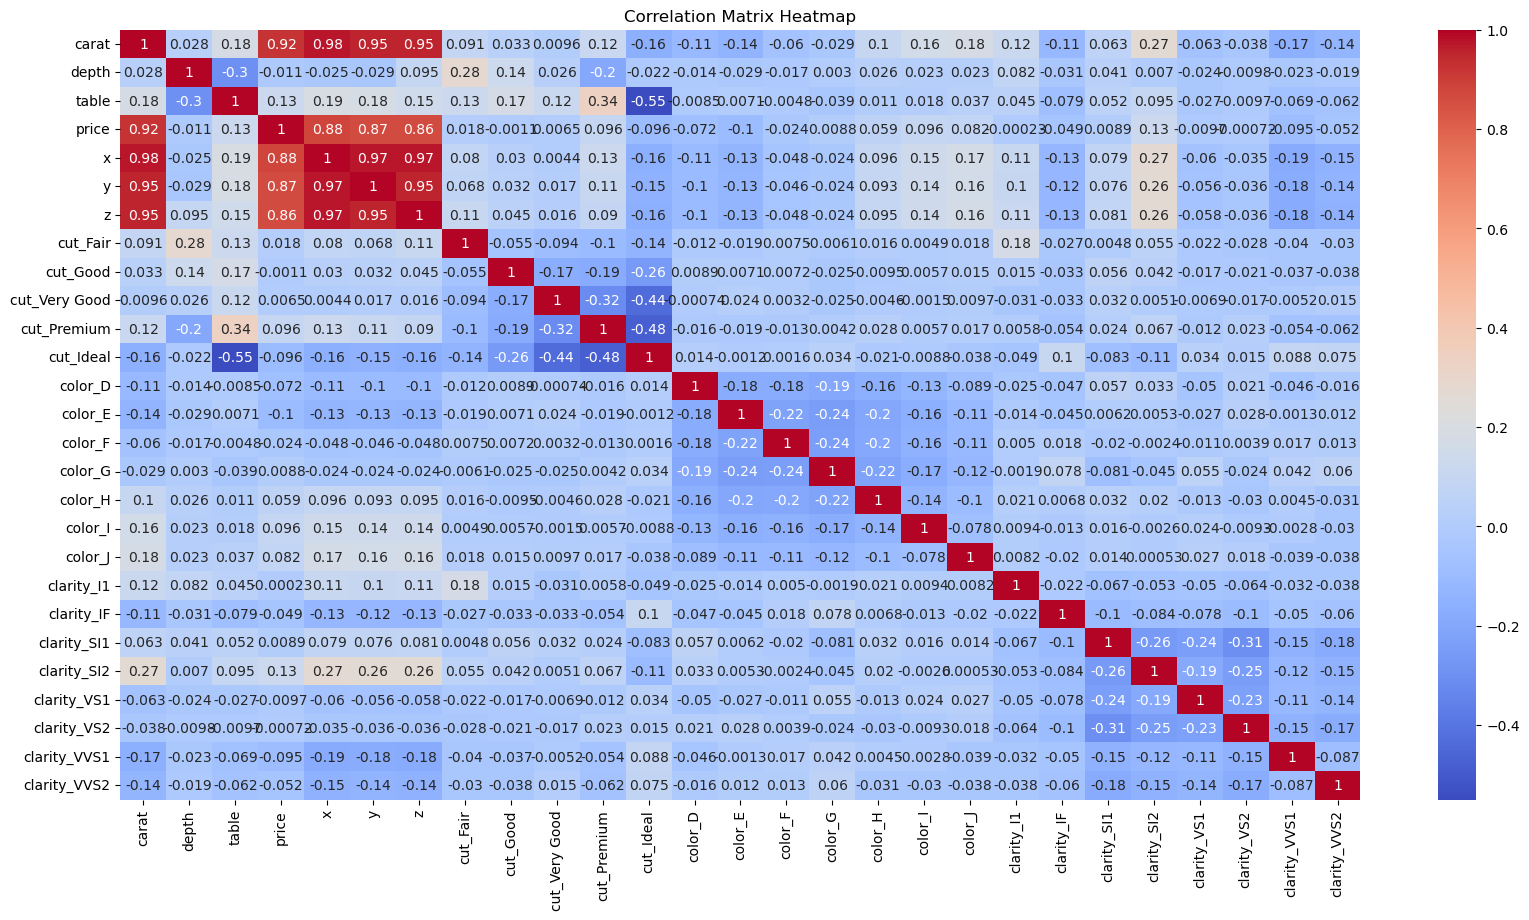

In [66]:
# Correlation matrix heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr(), cmap='coolwarm', annot=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

The correlation matrix above shows that price is highly correlated with carat, x, y and z.

## Feature Importance
Feature selection determines which features have the most influence on helping to determine the target. 

Correlation refers to how close two variables in terms of having a linear relationship with each other.

In [67]:
#split features and target (price)
X = data.drop('price', axis=1) 
y = data['price']

mutual_info = mutual_info_regression(X, y)

# Create a series with the feature names as index
mi_series = pd.Series(mutual_info, index=X.columns)
mi_series.sort_values(ascending=False, inplace=True)
print(mi_series)


carat            1.957639
y                1.491301
x                1.478109
z                1.430513
clarity_SI1      0.093118
clarity_VS2      0.086661
clarity_SI2      0.080925
color_E          0.074846
color_G          0.066348
color_D          0.066234
clarity_VVS2     0.055712
color_F          0.055398
table            0.053855
clarity_VVS1     0.051864
clarity_VS1      0.050077
cut_Ideal        0.047482
color_H          0.045143
cut_Premium      0.044566
clarity_IF       0.037288
depth            0.033430
color_I          0.033044
cut_Very Good    0.028238
color_J          0.018992
cut_Good         0.012255
cut_Fair         0.009653
clarity_I1       0.003850
dtype: float64


# Model Training

## Linear Regression

In [68]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43035, 26), (10759, 26), (43035,), (10759,))

In [69]:
# Linear Regression before scaling
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [70]:
# evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1215093.9038325055
Root Mean Squared Error: 1102.31297907287
R2 Score: 0.9202802581013377
Mean Absolute Error: 725.270321268135


### Predict Price of Diamond using Linear Regression before scaling

In [71]:
# price prediction
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price = model.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price}')

Actual Price: 1851
Predicted Price: 2630.1366980803386


c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


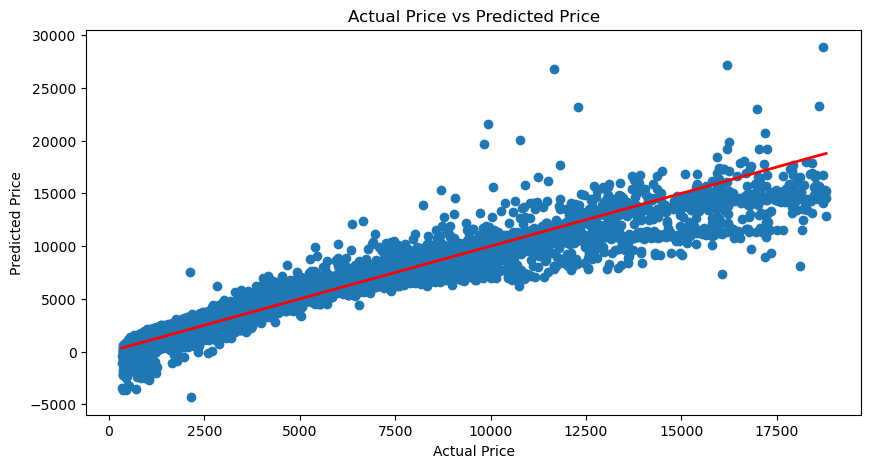

In [72]:
# plot actual vs predicted price
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()

### Scale the data

In [73]:
# normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
# Linear Regression after scaling
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# predict the price after scaling
y_pred = model.predict(X_test_scaled)

In [75]:
# Model Evaluation mse, rmse, r2, mae
mse_scaled = mean_squared_error(y_test, y_pred)
rmse_scaled = np.sqrt(mse)
r2_scaled = r2_score(y_test, y_pred)
mae_scaled = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse_scaled}') # square of the difference between the actual value and the predicted value
print(f'Root Mean Squared Error: {rmse_scaled}')
print(f'R2 Score: {r2_scaled}')  # ranges from 0 to 1, 1 means perfect prediction
print(f'Mean Absolute Error: {mae_scaled}') # absolute difference between the actual value and the predicted value

Mean Squared Error: 1215093.9038325078
Root Mean Squared Error: 1102.31297907287
R2 Score: 0.9202802581013376
Mean Absolute Error: 725.270321268136


In [76]:
# accuracy of the model
accuracy = model.score(X_test_scaled, y_test) * 100
print(f'Accuracy: {accuracy}')

Accuracy: 92.02802581013376


### Predict Price of diamond using Linear Regression after scaling

In [77]:
# given features, predict the price and show actual price
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price_scaled = model.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price_scaled}')

Actual Price: 1851
Predicted Price: -7444.9809438944485


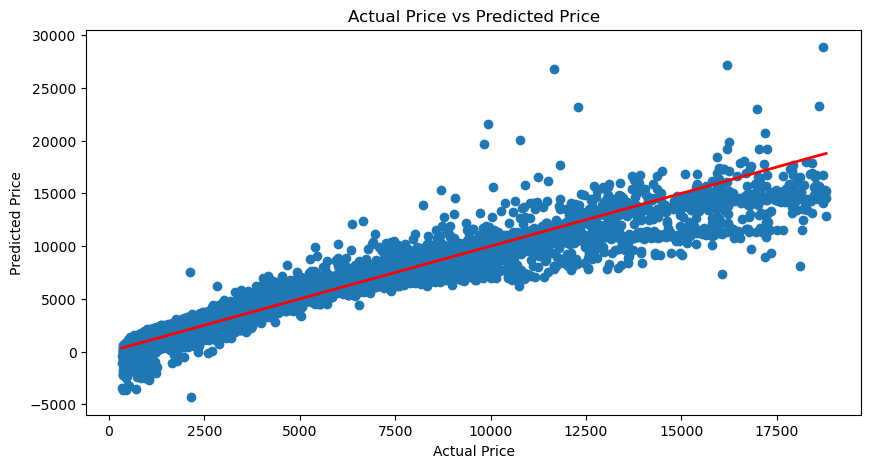

In [78]:
# plot the predicted price vs actual price with regression line
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()


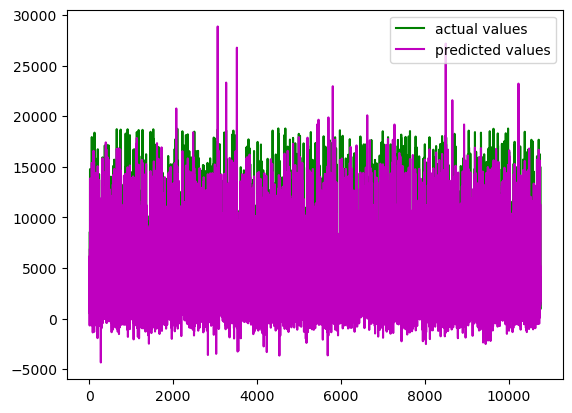

In [79]:
# plot for actual values and predicted values
# acutal values
plt.plot([i for i in range(len(y_test))],np.array(y_test), c='g', label="actual values")

# predicted values
plt.plot([i for i in range(len(y_test))],y_pred, c='m',label="predicted values")
plt.legend()
plt.show()

### Do L2 Regularization
adds squared magnitude of coefficients as penalty term to the loss function.

reduce model complexity

In [80]:
# Define the parameter grid
param_grid = {'alpha': [0.1, 1, 10, 100]}

# L2 Regularization
ridge = Ridge()
# Perform Grid Search
grid_search_l2 = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_l2.fit(X_train, y_train)

# Get the best parameters and model
best_params_l2 = grid_search_l2.best_params_
best_model_l2 = grid_search_l2.best_estimator_


In [81]:
# predict the price using the best model from L2 regularization
best_model_l2.fit(X_train, y_train)

y_pred_l2 = best_model_l2.predict(X_test_scaled)

c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


In [82]:
# Model Evaluation mse, rmse, r2, mae
mse_l2 = mean_squared_error(y_test, y_pred)
rmse_l2 = np.sqrt(mse_l2)
r2_l2 = r2_score(y_test, y_pred)
mae_l2 = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse_l2}')
print(f'Root Mean Squared Error: {rmse_l2}')
print(f'R2 Score: {r2_l2}')
print(f'Mean Absolute Error: {mae_l2}')

Mean Squared Error: 1215093.9038325078
Root Mean Squared Error: 1102.312979072871
R2 Score: 0.9202802581013376
Mean Absolute Error: 725.270321268136


In [83]:
# accuracy of l2 regularization
accuracy_l2 = best_model_l2.score(X_test, y_test) * 100
print(f'Accuracy of L2 Regularization: {accuracy_l2}')

Accuracy of L2 Regularization: 92.02715392968219


In [84]:
# predict price
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price_l2 = best_model_l2.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price_l2}')

Actual Price: 1851
Predicted Price: 2631.2546789301923


c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


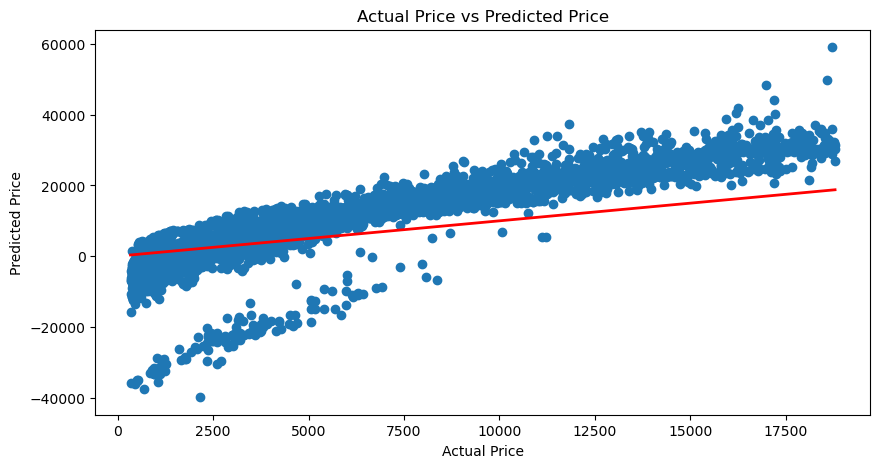

In [85]:
# Show plot of regression line
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_l2)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()


### Do L1 Regularization 
adds “absolute value of magnitude” of coefficient as penalty term to the loss function.

enables feature selection

In [86]:
# DEfine the parameter grid
param_grid = {'alpha': [0.1, 1, 10, 100]}

# L1 Regularization
lasso = Lasso()
# Perform Grid Search
grid_search_l1 = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_l1.fit(X_train, y_train)

# Get the best parameters and model
best_params_l1 = grid_search_l1.best_params_
best_model_l1 = grid_search_l1.best_estimator_

c:\Users\mch\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.898e+07, tolerance: 5.562e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\mch\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.014e+07, tolerance: 5.526e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\mch\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.953e+07, tolerance: 5.5

In [87]:
# predict the price with best model from l1 regularization
best_model_l1.fit(X_train, y_train)

y_pred_l1 = best_model_l1.predict(X_test)

c:\Users\mch\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.589e+07, tolerance: 6.916e+07
  model = cd_fast.enet_coordinate_descent(


In [88]:
# Model Evaluation mse, rmse, r2, mae
mse_l1 = mean_squared_error(y_test, y_pred)
rmse_l1 = np.sqrt(mse_l1)
r2_l1 = r2_score(y_test, y_pred)
mae_l1 = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse_l1}')
print(f'Root Mean Squared Error: {rmse_l1}')
print(f'R2 Score: {r2_l1}')
print(f'Mean Absolute Error: {mae_l1}')

Mean Squared Error: 1215093.9038325078
Root Mean Squared Error: 1102.312979072871
R2 Score: 0.9202802581013376
Mean Absolute Error: 725.270321268136


In [89]:
# Predict price
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price_l1 = best_model_l1.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price_l1}')

Actual Price: 1851
Predicted Price: 2629.8291550938734


c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


In [90]:
# accuracy of l1 regularization
accuracy_l1 = best_model_l1.score(X_test, y_test) * 100
print(f'Accuracy of L1 Regularization: {accuracy_l1}')

Accuracy of L1 Regularization: 92.02831367076288


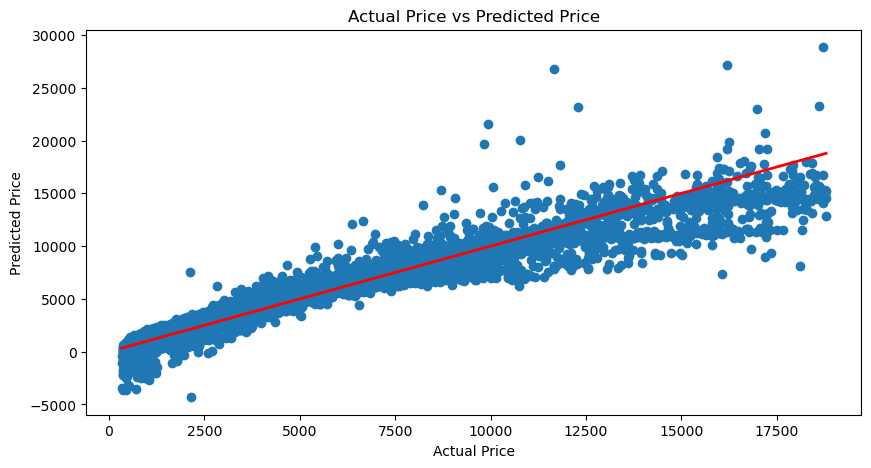

In [91]:
# Show plot of regression line
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_l1)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()

### Do L1+L2 Regularization

In [92]:
# Define the parameter grid using linspace for alpha and l1_ratio
param_grid = {
    'alpha': np.linspace(0.1, 100, 13),  # 13 values between 0.1 and 100
    'l1_ratio': np.linspace(0.1, 0.9, 9)  # 9 values between 0.1 and 0.9
}

# Elastic Net Regularization
elastic_net = ElasticNet()
# Perform Grid Search
grid_search_en = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_en.fit(X_train_scaled, y_train)

# Get the best parameters and model
best_params_en = grid_search_en.best_params_
best_model_en = grid_search_en.best_estimator_

best_params_en
best_model_en 

ElasticNet(alpha=0.1, l1_ratio=0.9)

In [93]:
# predict price using best model from elastic net
best_model_en.fit(X_train, y_train)

y_pred_en = best_model_en.predict(X_test)

In [94]:
# Model Evaluation mse, rmse, r2, mae
mse_l1l2 = mean_squared_error(y_test, y_pred)
rmse_l1l2 = np.sqrt(mse_l1l2)
r2_l1l2 = r2_score(y_test, y_pred)
mae_l1l2 = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse_l1l2}')
print(f'Root Mean Squared Error: {rmse_l1l2}')
print(f'R2 Score: {r2_l1l2}')
print(f'Mean Absolute Error: {mae_l1l2}')

Mean Squared Error: 1215093.9038325078
Root Mean Squared Error: 1102.312979072871
R2 Score: 0.9202802581013376
Mean Absolute Error: 725.270321268136


In [95]:
# calculate accuracy
accuracy_l1l2 = best_model_en.score(X_test, y_test) * 100
print(f'Accuracy: {accuracy_l1l2}')


Accuracy: 89.7441616744605


In [96]:
# Predict price
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price_l1l2 = best_model_en.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price_l1l2}')

Actual Price: 1851
Predicted Price: 2859.8537606930877


c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


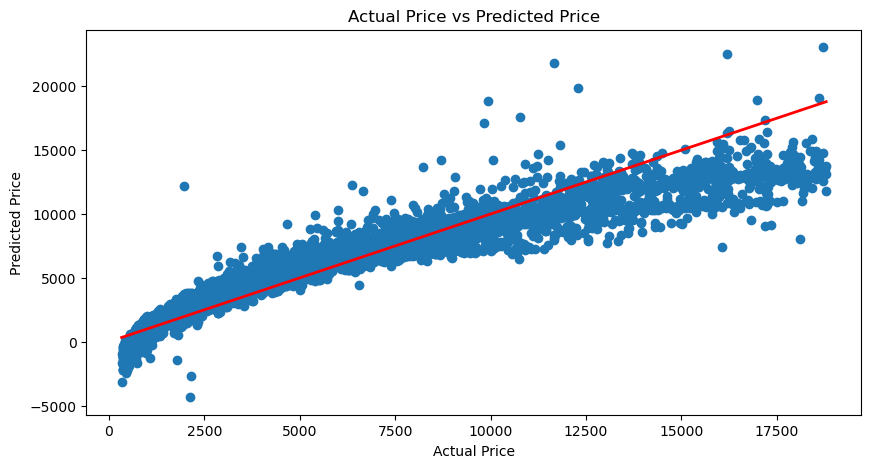

In [97]:
# Show plot of regression line
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_en)
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linewidth=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual Price vs Predicted Price')
plt.show()

## Random Forest

In [98]:
# model with 300 trees
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)

# train model on training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [99]:
# predict price on test data
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation mse, rmse, r2, mae
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f'Mean Squared Error: {mse_rf}')
print(f'Root Mean Squared Error: {rmse_rf}')
print(f'R2 Score: {r2_rf}')
print(f'Mean Absolute Error: {mae_rf}')


Mean Squared Error: 270784.2704328653
Root Mean Squared Error: 520.3693596214763
R2 Score: 0.9822344165491746
Mean Absolute Error: 261.84975938724364


In [100]:
# Calculate accuracy
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
accuracy_rf = 100 - mape_rf
print(f'Accuracy: {accuracy_rf}')

Accuracy: 93.50280925657373


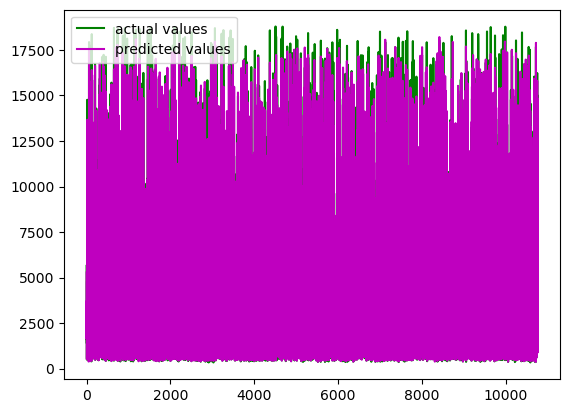

In [101]:
# actual values
plt.plot([i for i in range(len(y_test))],np.array(y_test), c='g', label="actual values")

# predicted values
plt.plot([i for i in range(len(y_test))],y_pred_rf, c='m',label="predicted values")
plt.legend()
plt.show()

# Comparison between Linear Regression and Random Forest


In [102]:
# show a table of mae, mse, rmse, r2 of linear regression and random forest
results = pd.DataFrame({
    'Linear Regression': [mae, mse, rmse, r2],
    'Linear Regression (Scaled)': [mae_scaled, mse_scaled, rmse_scaled, r2_scaled],
    'Ridge Regression (L2)': [mae_l2, mse_l2, rmse_l2, r2_l2],
    'Lasso Regression (L1)': [mae_l1, mse_l1, rmse_l1, r2_l1],
    'Elastic Net (L1L2)': [mae_l1l2, mse_l1l2, rmse_l1l2, r2_l1l2],
    'Random Forest': [mae_rf, mse_rf, rmse_rf, r2_rf]
}, index=['MAE', 'MSE', 'RMSE', 'R2'])
results

,Linear Regression,Linear Regression (Scaled),Ridge Regression (L2),Lasso Regression (L1),Elastic Net (L1L2),Random Forest
MAE,7.252703e+02,7.252703e+02,7.252703e+02,7.252703e+02,7.252703e+02,261.849759
MSE,1.215094e+06,1.215094e+06,1.215094e+06,1.215094e+06,1.215094e+06,270784.270433
RMSE,1.102313e+03,1.102313e+03,1.102313e+03,1.102313e+03,1.102313e+03,520.369360
R2,9.202803e-01,9.202803e-01,9.202803e-01,9.202803e-01,9.202803e-01,0.982234


### Predict Price of diamond using Random Forest

In [103]:
# Given features, predict the price and show actual price also
features = X_test.iloc[2]
actual_price = y_test.iloc[2]
predicted_price_rf = rf_model.predict([features])[0]
print(f'Actual Price: {actual_price}')
print(f'Predicted Price: {predicted_price_rf}')

Actual Price: 1851
Predicted Price: 1871.63


c:\Users\mch\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Comparison between Actual and Predicted Price between Linear Regression and Random Forest

In [104]:
# show the comaprison between the actual price and predicted price of two models in a table
comparison = pd.DataFrame({
    'Actual Price': actual_price,
    'Linear Regression': predicted_price,
    'Linear Regression (Scaled)': predicted_price_scaled,
    'LinearRegression L2': predicted_price_l2,
    'LinearRegression L1': predicted_price_l1,
    'LinearRegression L1L2': predicted_price_l1l2,
    'Random Forest': predicted_price_rf
}, index=['Diamond Price'])

comparison

,Actual Price,Linear Regression,Linear Regression (Scaled),LinearRegression L2,LinearRegression L1,LinearRegression L1L2,Random Forest
Diamond Price,1851,2630.136698,-7444.980944,2631.254679,2629.829155,2859.853761,1871.63


### Comparison between Accuracies of Linear Regression and Random Forest

In [105]:
accuracy_comparison = pd.DataFrame({
    'Linear Regression': [accuracy],
    'Linear Regression (L1)': [accuracy_l1],
    'Linear Regression (L2)': [accuracy_l2],
    'Linear Regression (L1L2)': [accuracy_l1l2],
    'Random Forest': [accuracy_rf]
}, index=['Accuracy'])

accuracy_comparison

,Linear Regression,Linear Regression (L1),Linear Regression (L2),Linear Regression (L1L2),Random Forest
Accuracy,92.028026,92.028314,92.027154,89.744162,93.502809
